# Bundle Width of Cytoskeleton Filaments

** Run the function below to define all the necessary functions <br> **
** Use the cell at the bottom to analyze movies **

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import filters, color, io
from scipy.ndimage import median_filter, distance_transform_edt
from scipy.signal import argrelextrema
# extra packages for a progress bar
from ipywidgets import FloatProgress
from IPython.display import display


def eucledean_distance_map(img, thresh_block_size = 21, denoise_level = 9):
    
    img_gray = color.rgb2gray(img) #convert to gray scale
    adaptive_thresh = filters.threshold_local(img_gray, block_size = thresh_block_size, offset=0) # sets the thershold values ...
    img_gray_thres = img_gray > adaptive_thresh # applies the threshold values
    img_denoise = median_filter(img_gray_thres, size = denoise_level) # reduce image noise by despeckle
    img_dist = distance_transform_edt(img_denoise) # estimate eucldean distance to the closest dark pixel
    return img_dist

def bundle_width(img_EDM, pixel_size): #takes eucledean distance map as input and pixel size in microns

    peaks = [] #empty list to save all the peaks for each line and each column

    for line in range(img_EDM.shape[0]):
        peaks_lines = argrelextrema(img_EDM[line,: ], np.greater, order =1)[0] # finds the peak positions for each line
        peaks_lines_dist = [img_EDM[line,: ][i] for i in peaks_lines] # saves peak 'intensity' for each position = distance from dark pixel
        peaks.append(peaks_lines_dist) # save each array of peaks for each line in the 'peak' list

    for column in range(img_EDM.shape[1]):
        peaks_columns = argrelextrema(img_EDM[:,column], np.greater, order =1)[0] # finds the peak positions for each line
        peaks_columns_dist = [img_EDM[:, column ][i] for i in peaks_columns] # saves peak 'intensity' for each position = distance from dark pixel
        peaks.append(peaks_columns_dist) # save each array of peaks for each line in the 'peak' list
    
    # pull all the peaks into a single array, discard NA values and correct for pixel size
    # width is equal to peak distance * 2
    
    width_dist = pd.Series(np.concatenate(peaks)).dropna() * pixel_size * 2
    
    width_mean = np.mean(width_dist)
    width_std = np.std(width_dist)
        
    return width_mean, width_std, width_dist

def bundle_width_estimation(filename, time_per_frame, cutoff = -1, step = 10, pixel_size = 1, save_files = False):
    ''' filename: path/filename of the movie to analyze; time_per_frame: in seconds; 
        cutoff: run analysis up to this frame number, runs for the whole movie by default (-1);
        step: frame interval to analyze instead of every frame
        pixel_size: in microns, equals to 1 micron by default (dummy calibration);
        save_files: save final tables as txt'''
    
    mov = io.imread(filename)
    mov = mov[ :cutoff:step]

    means = []  # to save bundles means
    stds  = []  # to save std
    sems  = []
    hists = []  # to save all histograms

    # to build a progress bar // fancy!
    bar = FloatProgress(description = 'Processing ...', bar_style= 'info', max = mov.shape[0])
    display(bar)

    for frame in mov:
        processed_image = eucledean_distance_map(frame) # pre-processed function defined above
        mean, std, histogram = bundle_width(processed_image, pixel_size) # function defined above

        means.append(mean)
        stds.append(std)
        sems.append(std/len(histogram))
        hists.append(histogram)
        
        bar.value += 1
        
    print('Done! Yay!')
    
    # SAVE VALUES
    time_array = np.array(range(0,len(mov))) * time_per_frame * step
    
    hists = pd.DataFrame(hists).T # all histograms as a data frame, each column = one time point in seconds 
    hists.columns = [time_array]
    
    bundle_width_table = pd.DataFrame([time_array, means, stds, sems]).T
    bundle_width_table.columns = ['time','bundle_mean','bundle_std', 'bundle_sem']
    
    if save_files == True:
        bundle_width_table.to_csv(str(filename)[:-4] + '_Bundle_Width_Table.txt', index=False)
        hists.to_csv(str(filename)[:-4] + '_All_Histograms.txt', index = False)
    
    time  = bundle_width_table.time
    means = bundle_width_table.bundle_mean
    stds  = bundle_width_table.bundle_std
    sems  = bundle_width_table.bundle_sem
    
    # PLOT FINAL RESULTS
    
    plt.figure(figsize = (8,3), dpi = 200)
    plt.subplot(1,2,1)
    plt.errorbar(time, means, color = 'darkblue', lw = 2, label = 'Mean')
    plt.fill_between(time, means - std, means + std, #define upper and lower error
                 color = 'blue', alpha=0.1, label = 'std');

    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Bundle width ($\mu$m)', fontsize=12)
    plt.tick_params(direction = 'in', top = False, right = False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(frameon = False)
          
    # plot all histograms 
    
    plt.subplot(1,2,2)

    nCurves = 0
    for col in hists:
        nCurves = nCurves + 1
        counts, bins = np.histogram(hists[col].dropna(), normed = True) # how to iterate over columns in pandas
        plt.plot(bins[:-1], counts, '-', lw = 0.5, color = plt.cm.Blues(nCurves*10))

    plt.xlabel('Bundle width ($\mu$m)', fontsize=12)
    plt.ylabel('PDF', fontsize=12)
    plt.tick_params(direction = 'in', top = False, right = False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);
    plt.subplots_adjust(wspace = 0.3)
    
    plt.savefig(filename +'_Bundle_width_results.png', bbox_inches="tight", transparent = True)
    
    return bundle_width_table, hists

### Analyze Image Stacks

FloatProgress(value=0.0, bar_style='info', description='Processing ...', max=113.0)

Done! Yay!


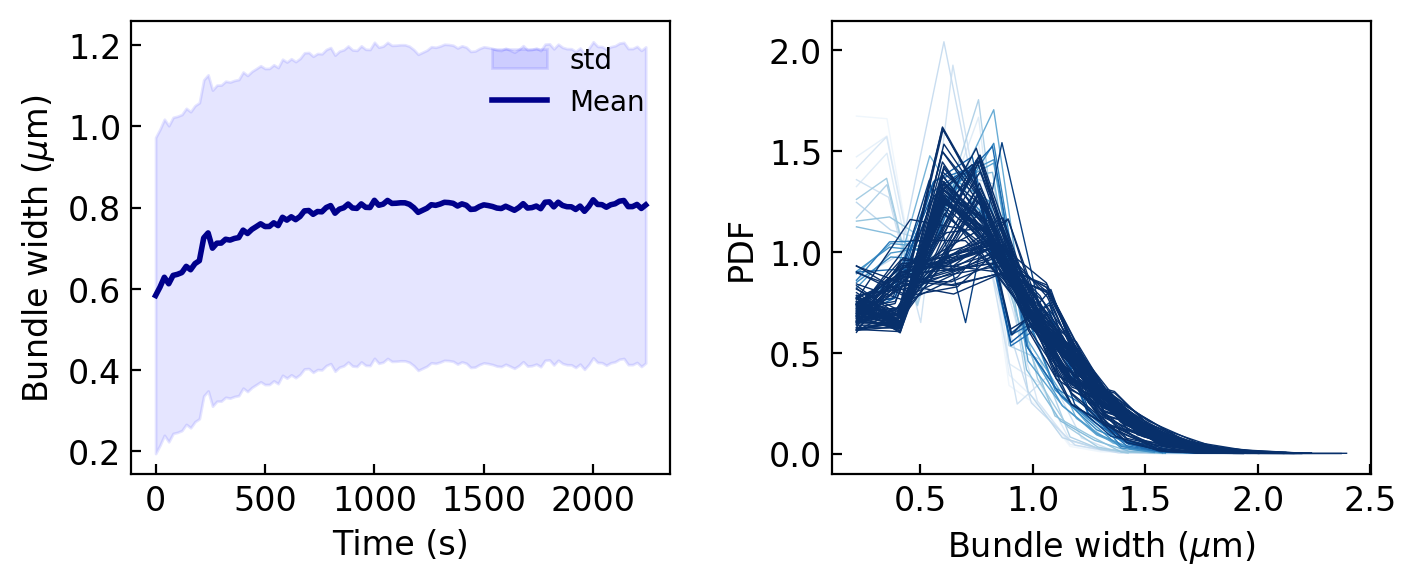

In [11]:
movie_to_analyze = 'ZapA 6uM 2018.01.16 ExpII.tif'
bundle_width_estimation(movie_to_analyze, time_per_frame = 2, pixel_size = 0.108, save_files=True);

FloatProgress(value=0.0, bar_style='info', description='Processing ...', max=110.0)

Done! Yay!


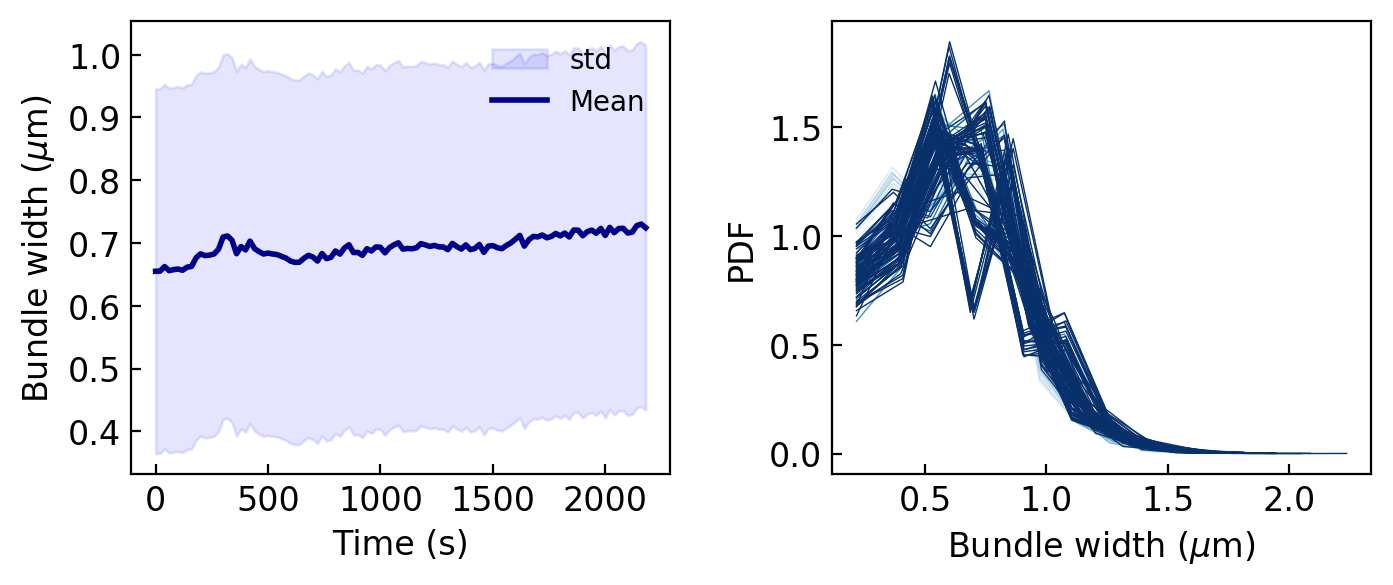

In [9]:
movie_to_analyze2 = 'FtsZ Alone 2018.01.12 ExpII.tf8'
table, hists = bundle_width_estimation(movie_to_analyze2, time_per_frame = 2, pixel_size = 0.108, save_files=True);